In [4]:
import sympy as sp
import jax.numpy as np
import matplotlib.pyplot as plt

from util.interfaces import Config, EqInfo, Hyperparameters, VarInfo
from main import run

In [5]:
config = Config(
  eq = EqInfo(
    name = 'S',
    function = lambda s: s.d2Sdx2 - s.k ** 2 * s.S / (1 + s.S) - s.dSdt,
  ),
  vars = {
    'x': VarInfo(bounds=(0, 1), integrable=False),
    'k': VarInfo(bounds=(0.01, 1), integrable=False, symbol=r'\sigma'),
    't': VarInfo(bounds=(0.001, 10), integrable=False),
    'S0': VarInfo(bounds=(0, 5), integrable=False, symbol=r'S_0')
  },
  conditions = [
    (1., lambda s: s.S.subs(s.t, 0)),
    (1., lambda s: s.S.subs(s.x, 1).subs(s.t, 0) - s.S0),
    (1., lambda s: s.S.subs(s.x, 1) - s.S0),
    (1., lambda s: s.dSdx.subs(s.x, 0)),
  ],
  preoperations = [
    lambda x, k, t, S0: 1,
    lambda x, k, t, S0: x,
    lambda x, k, t, S0: k,
    lambda x, k, t, S0: t,
    lambda x, k, t, S0: S0,
    lambda x, k, t, S0: x - k,
    lambda x, k, t, S0: 1 / sp.cosh(k),
  ],
  operations = [
    lambda z: 0,
    lambda z: 1,
    lambda z: z,
    lambda z: z**2,
    lambda z: z + 1,
    lambda z: 1 / z,
    lambda z: -z,
    lambda z: sp.cos(z),
    lambda z: sp.exp(z),
    lambda z: sp.cosh(z),
    lambda z: 1 / sp.cos(z),
  ],
  hyperparameters = Hyperparameters(
    lr = 0.00001,
    penalty = 1,
    cellcount = 4,
  ),
  epochs = 128,
  batchsize = 64,
  verbosity = 1,
  gradclip = True,
  seed = 2,
)

In [6]:
network, best, loss_histories = run(config)

15:28:01.256 [INFO] Constructed symbolic model
15:33:23.487 [INFO] Constructed loss equation
15:33:30.918 [INFO] Constructed JAXified model


UnboundLocalError: local variable 'opt_state' referenced before assignment

In [ ]:
best.loss

Array(6.6029634, dtype=float32)

In [ ]:
y_prediction_best = best.model_y.subs(zip(best.alphas, best.W))
print(sp.latex(y_prediction_best))

- 0.530156373977661 k + 0.530156373977661 x + 0.481119031042935 e^{0.345949351787567 k} + 0.125717446117174


In [ ]:
from jax import vmap
x = network.symbols.x
k = network.symbols.k
t = network.symbols.t
S0 = network.symbols.S0
y_pred_fn = sp.lambdify([x, k, t, S0], y_prediction_best)#, (0, None, None, None))

In [ ]:
y_pred_fn(np.array([0.5, 0.6]), np.array(0.1), np.array(0), np.array(1))

Array([0.83583456, 0.88885015], dtype=float32)

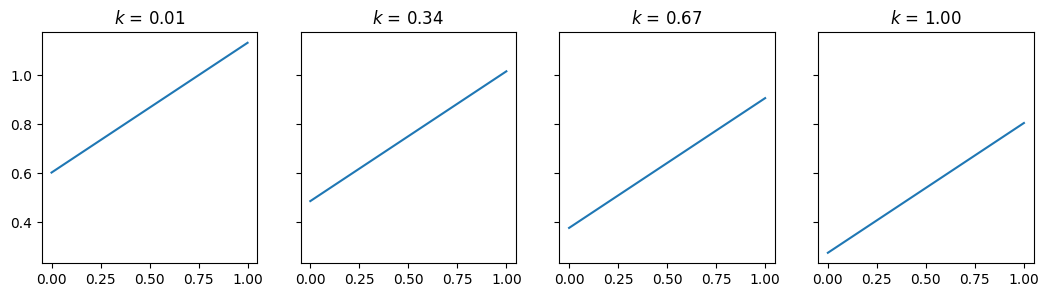

In [ ]:
x_try = np.linspace(0, 1, 50)
k_tries = np.linspace(0.01, 1, 4, True)
t_try = 0
S0_try = 1
fig, axs = plt.subplots(1, len(k_tries), sharey=True)
fig.set_size_inches(len(k_tries)*3.2, 3)

for ax, k_try in zip(axs, k_tries):
  ax.set_title(f'$k$ = {k_try:.2f}')
  ax.plot(x_try, y_pred_fn(x_try, k_try, t_try, S0_try), label=f'prediction')
  # ax.legend()
plt.show()